# Victor Møller Poulsen

In [7]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
from pymc3 import math
from scipy import stats

sns.set_context('talk')

# Portfolio 1

In the following exercises, we are going to analyse response time data  from a recent paper [(Legrand et al., 2021)](https://www.biorxiv.org/content/10.1101/2021.02.18.431871v1) using PyMC3.

In [8]:
# Load data frame
d = pd.read_csv('https://github.com/embodied-computation-group/CardioceptionPaper/raw/main/data/Del2_merged.txt')

## Exercise 1 - Preprocessing

This data frame contains behavioral results from a lot of participants, doing a lot of different tasks. The data of interest for us are stored in the `ConfidenceRT` column. This is the time the participant takes to rate a confidence rating scale. Before we go to the analysis part, we should filter this data frame a bit.

* Here we only want to analyze the modality labeled as `Intero`, and drop the other one. 
* We only want to keep the `Subject` and the `ConfidenceRT` columns. 
* Sometimes, no responses were made by the participant, so the column potentially contains NaN values that should be removed. 
* Because we are just testing new models here, we only want to analyze a sub-sample of the data to save time and memory, so we are going to analyze subjects whose ID ends with a `7` and drop the rest of the participants.

You should end up with a data frame containing 2 columns, 1158 rows, and the response time data from 20 participants in total. If you have difficulties doing this filtering process, you can just skip this question and use the entire `ConfidenceRT` column for the next questions.

In [9]:
# preprocessing: 

# first step (only Intero): 
d1 = d[d["Modality"] == "Intero"]

# second step (select only Subject & ConfidenceRT columns):
cols = ["Subject", "ConfidenceRT"]
d2 = d1[cols]

# third step (remove NAs)
d3 = d2.dropna()

# fourth step (ID ends with 7)
d4 = d3[d3["Subject"].str.endswith('7')]
d4 = d4.reset_index(drop=True)

# check unique IDs (length is right). 
len(d4.Subject.unique()) #perfect. 

20

## Exercise 2 - Gaussian model
There are many ways to describe response time distribution. The most intuitive and simple model would be to use a normal distribution and use the mean and precision of this distribution as parameters of interest for each subject.

We know from the experimental design that the response time cannot be less than 0 seconds or more than 5 seconds. Our first guess will be to use a normal distribution with a mean $\mu$ and a standard deviation $\sigma$. The mean might come from another normal distribution centered at 2.5. We don't want it to be too informative so the standard deviation will be set at 10. The standard deviation might come from a HalfCauchy distribution with a beta parameter set to `2`.

* Use PyMC3 to fit this model to the responses from the first participant only (`sub_0027`) and create one plot using Arviz to synthesize your results.
* Why did you choose this plot?
* Describe what is represented in your plot
* What information should we check if we want to make sure that the MCMC chain from this model can be trusted?

# A bit of preprocessing (not necessary)

In [10]:
d4_sub = d4[d4["Subject"] == "sub_0027"]
x = np.array(d4_sub["ConfidenceRT"])
x

array([1.4499332, 1.3398999, 1.1097915, 1.7189358, 1.4291097, 1.2217033,
       2.1630864, 1.6913309, 0.8544995, 0.9107431, 1.7215121, 1.0302576,
       2.0555562, 1.3060303, 1.202586 , 2.2136707, 1.1489728, 1.4894435,
       0.8913451, 2.1695289, 2.1906726, 0.5881197, 0.657134 , 1.887872 ,
       0.7561615, 1.0062258, 0.9921206, 3.4302822, 1.3470304, 1.5728866,
       0.5596704, 0.7637878, 0.8404033, 0.6058273, 0.6700964, 1.5768937,
       0.8636969, 2.0092213, 0.8846293, 1.6954633, 0.8754712, 1.5222184,
       0.8375095, 1.8781926, 2.8602884, 0.745708 , 1.2145839, 0.6156492,
       1.4264587, 0.6767579, 1.4524948, 1.2799597, 1.0575737, 1.1637345,
       0.9440678, 1.3573638, 1.0137525, 1.2037297, 0.8393237])

# Run the model

In [11]:
with pm.Model() as Gaussian: 
    
    # priors 
    μ = pm.Normal('μ', mu = 2.5, sd = 10)
    σ = pm.HalfCauchy('σ', beta = 2)
    
    # likelihood
    RT = pm.Normal('RT', mu = μ, sd = σ, observed = x)
    
    # trace
    t = pm.sample(2000)
    ppost = pm.sample_posterior_predictive(t, samples = 50)
    pprior = pm.sample_prior_predictive(samples = 50)
    
    # gather everything
    dctGaus = {"model": Gaussian,
           "trace": t,
           "ppost": ppost,
           "pprior": pprior}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 30 seconds.
C:\Anaconda\envs\bayes\lib\site-packages\pymc3\sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


# Choose only 1 plot: 

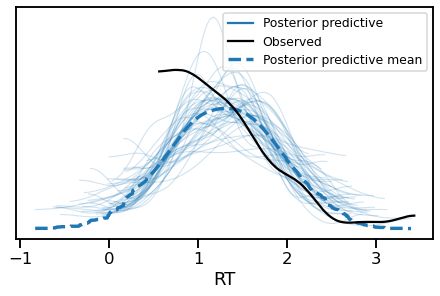

In [12]:
az.plot_ppc(az.from_pymc3(posterior_predictive = dctGaus.get('ppost'), 
                          model = dctGaus.get('model')));

This plot was chosen because it highlights the issue with modelling response times (RT) data <br/>
using a Gaussian. Response time is famously not normally distributed. <br/>
For instance, either the plot_trace or the summary functions from Arviz would not show us how bad the model really is.. 

## Exercise 3 - Precision

You want to compare your results with another model from the literature that describes the normal distribution using precision ($\lambda$), and not the standard deviation ($\sigma$). We know that: $$\sigma = \frac{1}{\sqrt{\lambda}}$$

* Use `az. summary` to extract the $\sigma$ value from the previous model, and convert it into a precision ($\lambda$) value.

In order to get the precision ($\lambda$) we need to isolate that. <br/>
$$ \lambda = \frac{1}{\sigma^2} $$ <br/>
We can do the same for the other values (sd, hdi). 

In [13]:
sum_val = az.summary(dctGaus.get('trace'))

In [14]:
sum_val

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,1.305,0.077,1.162,1.449,0.001,0.001,6656.0,4803.0,1.0
σ,0.589,0.057,0.488,0.697,0.001,0.001,6305.0,5283.0,1.0


In [15]:
# a bit manual
lambda_mean = 1 / (sum_val.iloc[1]["mean"])**2
lambda_sd = 1 / (sum_val.iloc[1]["sd"])**2
lambda_hdi3 = 1 / (sum_val.iloc[1]["hdi_3%"])**2
lambda_hdi97 = 1 / (sum_val.iloc[1]["hdi_97%"])**2
lambda_mcse_mean = sum_val.iloc[1]["mcse_mean"]
lambda_mcse_sd = sum_val.iloc[1]["mcse_sd"]
lambda_ess_bulk = sum_val.iloc[1]["ess_bulk"]
lambda_ess_tail = sum_val.iloc[1]["ess_tail"]
lambda_rhat = sum_val.iloc[1]["r_hat"]

# turn it into a row
lambda_row = pd.Series({'mean': lambda_mean,
                 'sd': lambda_sd,
                 'hdi_3%': lambda_hdi3,
                 'hdi_97%': lambda_hdi97, 
                 'mcse_mean': lambda_mcse_mean,
                 'mcse_sd': lambda_mcse_sd,
                 'ess_bulk': lambda_ess_bulk,
                 'ess_tail': lambda_ess_tail,
                 'r_hat': lambda_rhat}, 
                       name = "λ")

In [16]:
sum_val2 = sum_val.append(lambda_row)
sum_val2

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,1.305000,0.077000,1.16200,1.449000,0.001,0.001,6656.0,4803.0,1.0
σ,0.589000,0.057000,0.48800,0.697000,0.001,0.001,6305.0,5283.0,1.0
λ,2.882501,307.787011,4.19914,2.058422,0.001,0.001,6305.0,5283.0,1.0


Actually, it does not quite make sense for sd (perhaps not for hdi as well). <br/>
Will require more thought to convert those from sigma to lambda scale. <br/>
However, the lambda value (2.9) should be right I think.

## Exercise 4 - posterior predictive checks

It turns out that this gaussian model is a terrible one for many reasons. We can explore this a bit more by checking the posterior predictive.

* Extract the posterior predictive for this model using the default parameters from PyMC3.
* Plot posterior predictive checks using built-in Arviz function.
* What does this plot tells us? 
* What are the 2 main disadvantages here for response time data?

So.. We actually already did that in part 3. <br/>
The plot tells us that the RT data is definitely not normally distributed. <br/>
The main disadvantages for response time data are: <br/>
** typically long tails (here capped at 5 sec. though). <br/>
** typically a lot of pretty short/fast (& always non-negative) observations. 

## Exercise 5 - A better model

The normal distribution is indeed a poor fit for response time data. Other sources suggest that the Gamma distribution or the shifted Wald distribution might do a better job (see [this paper](https://www.frontiersin.org/articles/10.3389/fpsyg.2019.00102/full)). You can find all these distributions already implemented in PyMC3.

Using the same data from subject 27, fit, plot, and summarize the following models separately.

* The gamma model

$$ y \sim \mathcal{Gamma}(mu=\alpha, sigma=\beta)$$
$$ \alpha \sim \mathcal{Uniform}(0, 5)$$
$$ \beta \sim  \mathcal{Uniform}(0, 5)$$

* The Wald model

$$ y \sim \mathcal{Wald}(\mu, \lambda)$$
$$ \mu \sim \mathcal{Uniform}(0, 5)$$
$$ \lambda \sim  \mathcal{Uniform}(0, 20)$$

In [17]:
# implementing gamma model.
with pm.Model() as gamma: 
    
    # priors 
    α = pm.Uniform('α', lower = 0, upper = 5)
    β = pm.Uniform('β', lower = 0, upper = 5)
    
    # likelihood
    RT = pm.Gamma('RT', alpha = α, beta = β, observed = x)
    
    # trace
    t = pm.sample(2000, tune = 2000, target_accept = .95)
    ppost = pm.sample_posterior_predictive(t, samples = 50)
    pprior = pm.sample_prior_predictive(samples = 50)
    
    # gather everything
    dctGamma = {"model": gamma,
           "trace": t,
           "ppost": ppost,
           "pprior": pprior}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 40 seconds.
The number of effective samples is smaller than 25% for some parameters.
C:\Anaconda\envs\bayes\lib\site-packages\pymc3\sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [18]:
# implementing wald model
with pm.Model() as wald: 
    
    # priors 
    μ = pm.Uniform('μ', lower = 0, upper = 5)
    λ = pm.Uniform('λ', lower = 0, upper = 20)
    
    # likelihood
    RT = pm.Wald('RT', mu = μ, lam = λ, observed = x)
    
    # trace
    t = pm.sample(2000, tune = 2000, target_accept = .95)
    ppost = pm.sample_posterior_predictive(t, samples = 50)
    pprior = pm.sample_prior_predictive(samples = 50)
    
    # gather everything
    dctWald = {"model": wald,
           "trace": t,
           "ppost": ppost,
           "pprior": pprior}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [λ, μ]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 37 seconds.
C:\Anaconda\envs\bayes\lib\site-packages\pymc3\sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


## Exercise 6 - Plotting model results

Using the parameters estimates from the previous models, Matplotlib, Seaborn, and the `scipy.stats`module, try to reproduce the following plot
![title](https://github.com/LegrandNico/CognitiveModeling/raw/master/notebooks/data/wald_gamma.png)
:

**Hint**: You can use the gamma function from Scipy to estimate the probability density function, but you will have to create your own Wald function to make it work with the parameters `mu` and `lam` estimated by PyMC3 (see the formula [here](https://en.wikipedia.org/wiki/Inverse_Gaussian_distribution)).

In [19]:
# need x-grid for several things: 
# cannot be zero because we get issues with 0-division in Wald formula
x_grid = np.linspace(0.1, 5, 1000)

In [20]:
# getting values we need for the gamma distribution:
a_Gamma = dctGamma.get('trace')['α'].mean()
b_Gamma = dctGamma.get('trace')['β'].mean()

In [21]:
# getting values we need for the wald distribution: 
μ_Wald = dctWald.get('trace')['μ'].mean()
λ_Wald = dctWald.get('trace')['λ'].mean()

# The Wald formula
$$f(x; \mu, \lambda) = \sqrt{\frac{\lambda}{2 \cdot \pi \cdot x^3}} \cdot exp \left( - \frac{\lambda(x - \mu)^2}{2 \mu^2 x} \right)$$

In [22]:
# we need math
import math

In [23]:
def Wald(x, μ, λ):
    return math.sqrt( λ / (2 * math.pi * (x**3))) * math.exp( - (λ * (x - μ)**2) / (2 * (μ**2) * x))

In [24]:
# now we apply this function to all point along our x_grid. 
yWald = [Wald(x, μ_Wald, λ_Wald) for x in x_grid]

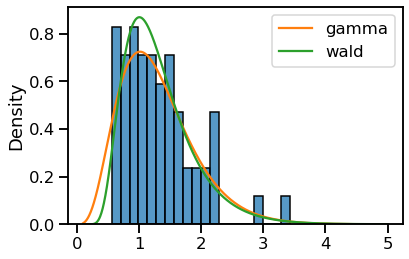

In [25]:
# the raw data
sns.histplot(x, stat = "density", bins = 20)

# the gamma distribution
yGamma = stats.gamma.pdf(x_grid, a = a_Gamma, scale = 1/b_Gamma)
plt.plot(x_grid, yGamma, color = "C1", label = "gamma")
plt.plot(x_grid, yWald, color = "C2", label = "wald")

plt.legend()
plt.plot();

Makes sense that Wald is better as it assigns less probability mass to very low values (below 0.5) that do not really seem to be present in the data. However, the gamma-distribution is not quite like the one depicted in the image from you. Are you sure that what you have shown in the picture is actually a gamma-distribution?

## Exercise 6 - Model comparison

Compare the previous models (normal distribution, Gamma, Wald). Which one should we choose? What are the metrics/indexes you use to make your decision?

LOO is generally considered superior to WAIC so we will compare the models using LOO. <br/>
LOO is also the default option in e.g. arvis compare, so we'll use that. 

In [26]:
# We can see that WALD is preferred. 
# It has weight = 1 which is not surprising for stacking. 
# Since Wald and Gamma are pretty similar it will assign almost all weight to the best model.
# Gaussian is pretty different, so even though it is worse (worst rank) it will get more weight than Gamma. 
loo_comp = az.compare({"Gaussian": dctGaus.get('trace'), 
                          "Gamma": dctGamma.get('trace'),
                          "Wald": dctWald.get('trace')})
loo_comp

C:\Anaconda\envs\bayes\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Wald,0,-43.738496,1.816345,0.000000,1.000000e+00,6.212389,0.000000,False,log
Gamma,1,-45.569178,1.006107,1.830682,0.000000e+00,5.469587,1.064783,False,log
Gaussian,2,-53.455974,3.059559,9.717478,1.463274e-13,8.425007,3.953943,False,log


## Exercise 7 - Decision

Imagine the following (completely fictitious) situation: Previous researches have shown that the $\mu$ parameter estimated from the Wald distribution is associated with the anxiety level of the participant. The lower this parameter is, the faster the participant is at confidence rating, and the greater the anxiety level is. If $\mu$ is below 1.2, the anxiety level is considered clinically relevant and the participant should be oriented to a specialist.

You want to make a decision concerning subject 27, and you want to make it probabilistically (i.e. you want to take the decision, but also estimate how sure you are about this decision).

* Given your estimation of $\mu$ from the previous model, do you consider this score to be clinically relevant here?
* What is the probability that $\mu$ is acless thany below 1.2 for this participant?

array([[<AxesSubplot:title={'center':'μ'}>,
        <AxesSubplot:title={'center':'μ'}>],
       [<AxesSubplot:title={'center':'λ'}>,
        <AxesSubplot:title={'center':'λ'}>]], dtype=object)

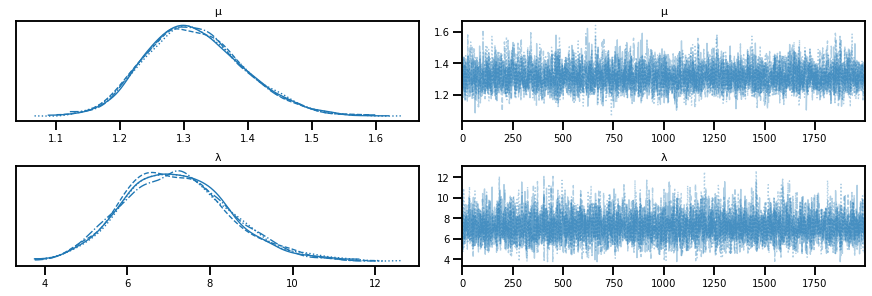

In [27]:
# no: μ has almost all probability mass above 1.2 
az.plot_trace(dctWald.get('trace'))

In [28]:
# take out values from our trace (all four). 
μ_trace = dctWald.get('trace')['μ']

# define threshold
threshold = 1.2

# how many valuese below 1.2
below = np.count_nonzero(μ_trace < 1.2)
total = len(μ_trace)

# ratio
fraction = total / below
fraction

21.62162162162162

18.69% of the probability mass has $\mu < 1.2$. 
This is probably not clinically relevant, although I have no idea.

## Exercise 8 - Hierarchical model

Using the entire dataset this time (20 subjects), we are going to fit a hierarchical Wald model. Instead of fixing the prior of the parameters of the Wald function, we want to sample them from hyperpriors (i.e each participant will have its own $\mu$ and $\lambda$ parameters coming from a unique normal distributionm and we want to estimate the mean and standard deviation of these distributions). The hierarchical model for $i = 20$ participants is defined by:

$$ y_{i} \sim \mathcal{Wald}(\mu_{i}, \lambda_{i})$$
$$ \mu_{i} \sim \mathcal{N}(\mu_{\mu}, \sigma_{\mu})$$
$$ \lambda_{i} \sim  \mathcal{N}(\mu_{\lambda}, \sigma_{\lambda})$$

$$\mu_{\mu} \sim \mathcal{Uniform}(0, 100)$$
$$\mu_{\lambda} \sim \mathcal{Uniform}(0, 100)$$

$$\sigma_{\mu} \sim \mathcal{HalfCauchy}(10)$$
$$\sigma_{\lambda} \sim \mathcal{HalfCauchy}(10)$$


In [29]:
## recall that this is d4 (created earlier)
d4.head(5)

,Subject,ConfidenceRT
0,sub_0027,1.449933
1,sub_0027,1.339900
2,sub_0027,1.109791
3,sub_0027,1.718936
4,sub_0027,1.429110


In [30]:
# a slight bit of preprocessing
n_participants = len(d4.Subject.unique())
x = np.array(d4["ConfidenceRT"])
idx = pd.Categorical(d4['Subject']).codes

In [31]:
# this takes a couple of minutes. 
with pm.Model() as hierarchical:
    
    # hyper priors
    μ_μ = pm.Uniform('μ_μ', 0, 100)
    μ_λ = pm.Uniform('μ_λ', 0, 100)
    
    σ_μ = pm.HalfCauchy('σ_μ', 10)
    σ_λ = pm.HalfCauchy('σ_λ', 10)
    
    # Independent parameters for each participant
    μ = pm.Normal("μ", mu = μ_μ, sigma = σ_μ, shape = n_participants)
    λ = pm.Normal("λ", mu = μ_λ, sigma = σ_λ, shape = n_participants)
    
    # now the wald model 
    y = pm.Wald('y', mu = μ[idx], lam = λ[idx], observed = x)
    
    # trace
    t = pm.sample(1000, tune = 2000)
    ppost = pm.sample_posterior_predictive(t, samples = 50)
    pprior = pm.sample_prior_predictive(samples = 50)
    
    
    # gather everything
    dctPool = {"model": hierarchical,
               "trace": t,
               "ppost": ppost,
               "pprior": pprior}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [λ, μ, σ_λ, σ_μ, μ_λ, μ_μ]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 125 seconds.
The number of effective samples is smaller than 25% for some parameters.
C:\Anaconda\envs\bayes\lib\site-packages\pymc3\sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


C:\Anaconda\envs\bayes\lib\site-packages\pymc3\distributions\continuous.py:1048: RuntimeWarning: invalid value encountered in sqrt
  - mu / (2.0 * lam) * np.sqrt(4.0 * mu * lam * v + (mu * v) ** 2)


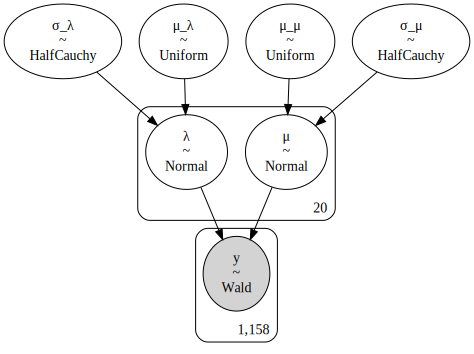

In [32]:
# check whether we did it correctly. 
pm.model_to_graphviz(dctPool.get("model"))

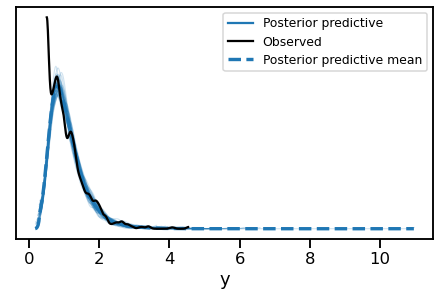

In [33]:
# starting to look pretty reasonable. 
az.plot_ppc(az.from_pymc3(posterior_predictive = dctPool.get('ppost'), 
                          model = dctPool.get('model')));

array([[<AxesSubplot:title={'center':'μ'}>,
        <AxesSubplot:title={'center':'μ'}>],
       [<AxesSubplot:title={'center':'λ'}>,
        <AxesSubplot:title={'center':'λ'}>],
       [<AxesSubplot:title={'center':'μ_μ'}>,
        <AxesSubplot:title={'center':'μ_μ'}>],
       [<AxesSubplot:title={'center':'μ_λ'}>,
        <AxesSubplot:title={'center':'μ_λ'}>],
       [<AxesSubplot:title={'center':'σ_μ'}>,
        <AxesSubplot:title={'center':'σ_μ'}>],
       [<AxesSubplot:title={'center':'σ_λ'}>,
        <AxesSubplot:title={'center':'σ_λ'}>]], dtype=object)

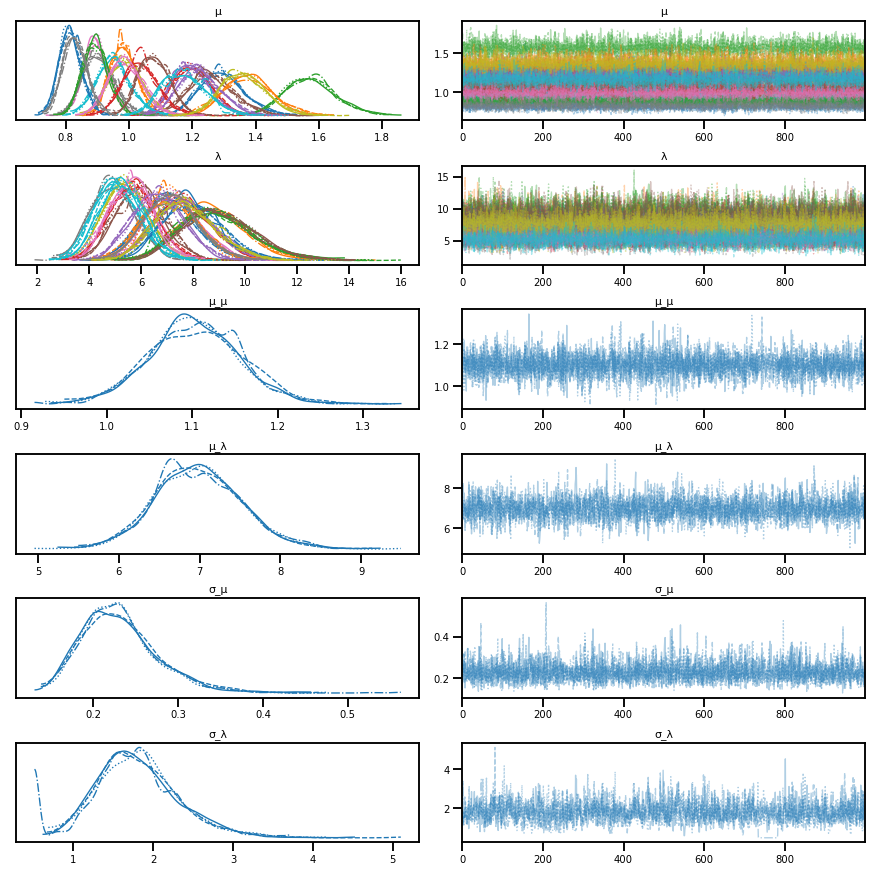

In [34]:
# looks good. 
az.plot_trace(dctPool.get('trace'))

The model looks reasonable (more or less). 
Concerning the clinical relevance (below 1.2) we see that for a handful of our participants they have a lot of probability mass for mu < 1.2.